In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture



In [2]:
categorias=pd.read_csv("../data_raw/categorias.csv")
clientes=pd.read_csv("../data_raw/clientes.csv")
productos=pd.read_csv("../data_raw/productos.csv")
ventas=pd.read_csv("../data_raw/ventas.csv")
metodos_pago=pd.read_csv("../data_raw/metodos_pago.csv")
display(categorias.head())
display(clientes.head())
display(productos.head())
display(ventas.head())
display(metodos_pago.head())

,ID_Categoria,Categoría,Descripción
0,1,Lácteos,"Productos lácteos frescos y procesados, como l..."
1,2,Carnicería,"Carnes frescas y procesadas, como carne de vac..."
2,3,Panadería,"Productos horneados frescos, como pan, factura..."
3,4,Frutas y Verduras,"Frutas y verduras frescas, locales e importada..."
4,5,Congelados,"Productos congelados, como papas fritas, empan..."


,ID_Cliente,Nombre,Apellido,Email,Fecha_Resgistro,Región
0,1,Karisa,Cromett,kcromett0@imageshack.us,19/11/2023,Patagonia
1,2,Lenette,Seabert,lseabert1@yahoo.co.jp,07/05/2023,Patagonia
2,3,Buddy,Silverson,bsilverson2@howstuffworks.com,27/03/2023,Patagonia
3,4,Dan,Parkin,dparkin3@virginia.edu,26/10/2023,Buenos Aires
4,5,Conney,Cassella,ccassella4@who.int,31/03/2023,Centro


,ID_Producto,Nombre_producto,Categoría,Precio_Unitario,Stock
0,1,Leche,Lácteos,"12,24",3327
1,2,Yogur,Lácteos,"5,21",3358
2,3,Queso cremoso,Lácteos,"17,23",3167
3,4,Queso rallado,Lácteos,"19,23",2099
4,5,Manteca,Lácteos,"5,65",4929


,ID_Venta,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado
0,919,31/01/2024,10,25,5,1,Completa
1,947,31/01/2024,106,5,1,4,Completa
2,1317,31/1/2024,235,25,3,3,Completa
3,1607,31/1/2024,114,15,5,1,Completa
4,2038,31/1/2024,132,2,5,4,Completa


,ID_Metodo,Método,Descripción
0,1,Efectivo,"Pago en dinero en efectivo, sin intermediarios..."
1,2,Tarjeta de Crédito,Pago con tarjetas emitidas por bancos y financ...
2,3,Tarjeta de Débito,Pago con tarjetas que debitán directamente de ...
3,4,Mercado Pago,Plataforma de pagos online que permite realiza...
4,5,Transferencia,Pago realizado a través de una transferencia d...


In [3]:
productos["Precio_Unitario"]=productos["Precio_Unitario"].str.replace(",",".").astype(float)

In [4]:
df=ventas.merge(clientes, on="ID_Cliente",how="inner")
df.drop(columns=["Email"],inplace=True)
df = df.merge(productos[["ID_Producto", "Precio_Unitario"]], on="ID_Producto", how="inner")
df["Cantidad_dinero"]=df["Cantidad"]*df["Precio_Unitario"]
df

,ID_Venta,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Nombre,Apellido,Fecha_Resgistro,Región,Precio_Unitario,Cantidad_dinero
0,919,31/01/2024,10,25,5,1,Completa,Stephenie,Sexty,23/11/2023,Buenos Aires,15.45,77.25
1,947,31/01/2024,106,5,1,4,Completa,Benedikta,Condon,23/06/2023,NEA,5.65,5.65
2,1317,31/1/2024,235,25,3,3,Completa,Cloe,Brun,11/12/2023,NEA,15.45,46.35
3,1607,31/1/2024,114,15,5,1,Completa,Fabien,Roskam,11/04/2023,Centro,3.51,17.55
4,2038,31/1/2024,132,2,5,4,Completa,Cassie,Corish,14/12/2023,Buenos Aires,5.21,26.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024,954,30/12/2024,44,12,6,4,Completa,Cyrill,Runge,17/09/2023,Buenos Aires,8.12,48.72
3025,1390,30/12/2024,26,31,3,4,Completa,Byrom,Soro,05/07/2023,Centro,5.24,15.72
3026,1519,30/12/2024,246,11,3,3,Completa,Almira,Zottoli,28/09/2023,NEA,11.23,33.69
3027,2147,30/12/2024,231,22,2,1,Pendiente,Rani,Chattelaine,13/12/2023,Patagonia,4.21,8.42




En esta parte utilizamos **rango intercuartílico (IQR)** para identificar *outliers*  en la columna `Precio_Unitario` del DataFrame. Se calculan los cuartiles Q1 (percentil 25) y Q3 (percentil 75), y luego se determina el IQR como la diferencia entre ambos. Se consideran outliers aquellos precios que se encuentran fuera del rango definido por:

$$
[Q1 - 1.5 \times \text{IQR},\ Q3 + 1.5 \times \text{IQR}]
$$

Los valores que están por debajo o por encima de este rango se filtran y se almacenan en un nuevo DataFrame llamado `outliers`. 




In [5]:
# Detección de outliers en Precio_Unitario 
Q1 = df["Precio_Unitario"].quantile(0.25)
Q3 = df["Precio_Unitario"].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df["Precio_Unitario"] < Q1 - 1.5 * IQR) | (df["Precio_Unitario"] > Q3 + 1.5 * IQR)]
print(f"Outliers detectados en Precio_Unitario: {len(outliers)}")

Outliers detectados en Precio_Unitario: 81


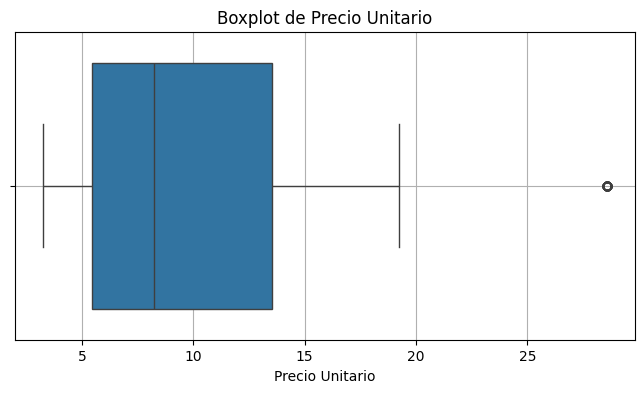

In [6]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["Precio_Unitario"])
plt.title("Boxplot de Precio Unitario")
plt.xlabel("Precio Unitario")
plt.grid(True)
plt.show()

In [7]:
outlier_counts = outliers["ID_Producto"].value_counts()
print(outlier_counts.head(10))


ID_Producto
6    81
Name: count, dtype: int64


In [8]:
outliers = outliers.merge(productos[["ID_Producto", "Nombre_producto"]], on="ID_Producto", how="left")
print(outliers[["ID_Producto", "Nombre_producto", "Precio_Unitario"]].sort_values(by="Precio_Unitario"))

# No es outlier realmente es un producto costoso, por lo cual no lo eliminamos.


    ID_Producto Nombre_producto  Precio_Unitario
0             6           Asado            28.56
1             6           Asado            28.56
2             6           Asado            28.56
3             6           Asado            28.56
4             6           Asado            28.56
..          ...             ...              ...
76            6           Asado            28.56
77            6           Asado            28.56
78            6           Asado            28.56
79            6           Asado            28.56
80            6           Asado            28.56

[81 rows x 3 columns]


In [9]:
df=df.merge(productos[["ID_Producto","Stock"]], on="ID_Producto", how="inner")

In [10]:
df = df.merge(productos[["ID_Producto", "Categoría"]], on="ID_Producto", how="left")
ventas_categoria = df.groupby("Categoría")["Cantidad_dinero"].sum()

In [11]:
dict_stock=productos.set_index("ID_Producto")["Stock"].to_dict()
print(dict_stock)
cantidad_de_producto_actual=[]
for cantidad, id_producto in zip(df["Cantidad"], df["ID_Producto"]):
    dict_stock[id_producto]-=cantidad
    cantidad_de_producto_actual.append(dict_stock[id_producto])
    if dict_stock[id_producto]<=0:
        print(f"Stock acabado para el producto {id_producto}")
print(dict_stock)
df["Producto_actual_stock"]=cantidad_de_producto_actual
df

{1: 3327, 2: 3358, 3: 3167, 4: 2099, 5: 4929, 6: 5137, 7: 4068, 8: 3140, 9: 4051, 10: 2429, 11: 1726, 12: 1619, 13: 2228, 14: 3125, 15: 4043, 16: 3189, 17: 3383, 18: 4720, 19: 4041, 20: 1541, 21: 2800, 22: 3545, 23: 3731, 24: 2908, 25: 1640, 26: 1688, 27: 4978, 28: 3637, 29: 2455, 30: 1363, 31: 2771, 32: 5057, 33: 2837, 34: 4769, 35: 1437, 36: 4578, 37: 1506, 38: 2182}
{1: 3051, 2: 3085, 3: 2894, 4: 1840, 5: 4629, 6: 4838, 7: 3775, 8: 2820, 9: 3799, 10: 2174, 11: 1472, 12: 1319, 13: 1969, 14: 2908, 15: 3779, 16: 2959, 17: 3084, 18: 4506, 19: 3793, 20: 1314, 21: 2534, 22: 3320, 23: 3426, 24: 2631, 25: 1308, 26: 1306, 27: 4620, 28: 3409, 29: 2102, 30: 1120, 31: 2471, 32: 4725, 33: 2605, 34: 4487, 35: 1131, 36: 4362, 37: 1249, 38: 1861}


,ID_Venta,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Nombre,Apellido,Fecha_Resgistro,Región,Precio_Unitario,Cantidad_dinero,Stock,Categoría,Producto_actual_stock
0,919,31/01/2024,10,25,5,1,Completa,Stephenie,Sexty,23/11/2023,Buenos Aires,15.45,77.25,1640,Congelados,1635
1,947,31/01/2024,106,5,1,4,Completa,Benedikta,Condon,23/06/2023,NEA,5.65,5.65,4929,Lácteos,4928
2,1317,31/1/2024,235,25,3,3,Completa,Cloe,Brun,11/12/2023,NEA,15.45,46.35,1640,Congelados,1632
3,1607,31/1/2024,114,15,5,1,Completa,Fabien,Roskam,11/04/2023,Centro,3.51,17.55,4043,Panadería,4038
4,2038,31/1/2024,132,2,5,4,Completa,Cassie,Corish,14/12/2023,Buenos Aires,5.21,26.05,3358,Lácteos,3353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024,954,30/12/2024,44,12,6,4,Completa,Cyrill,Runge,17/09/2023,Buenos Aires,8.12,48.72,1619,Panadería,1319
3025,1390,30/12/2024,26,31,3,4,Completa,Byrom,Soro,05/07/2023,Centro,5.24,15.72,2771,Galletitas y Snacks,2471
3026,1519,30/12/2024,246,11,3,3,Completa,Almira,Zottoli,28/09/2023,NEA,11.23,33.69,1726,Carnicería,1472
3027,2147,30/12/2024,231,22,2,1,Pendiente,Rani,Chattelaine,13/12/2023,Patagonia,4.21,8.42,3545,Frutas y Verduras,3320


In [12]:
productos_vendidos=df.groupby("ID_Producto")["Producto_actual_stock"].min().reset_index()
productos_vendidos=productos_vendidos.merge(productos[["ID_Producto","Stock"]], on="ID_Producto", how="inner")
productos_vendidos["Cantidad_vendida"]=productos_vendidos["Stock"]-productos_vendidos["Producto_actual_stock"]
productos_vendidos.sort_values("Cantidad_vendida", ascending=False).reset_index(drop=True)

,ID_Producto,Producto_actual_stock,Stock,Cantidad_vendida
0,26,1306,1688,382
1,27,4620,4978,358
2,29,2102,2455,353
3,25,1308,1640,332
4,32,4725,5057,332
5,38,1861,2182,321
6,8,2820,3140,320
7,35,1131,1437,306
8,23,3426,3731,305
9,12,1319,1619,300




#### Distribución de ingresos por venta
La gráfica de distribución de ingresos por venta muestra cómo se reparten los valores de la columna Cantidad_dinero, que se obtiene multiplicando la cantidad de productos vendidos por su precio unitario (Cantidad × Precio_Unitario). Este histograma indica cuántas ventas generaron ciertos niveles de ingreso. La mayoría de las ventas producen ingresos bajos (entre 5 y 40 unidades), mientras que las ventas con ingresos altos son mucho menos frecuentes, lo que genera una distribución asimétrica hacia la derecha. 

####  Matriz de correlación

La matriz de correlación muestra la relación entre tres variables numéricas del conjunto de datos:

- Cantidad: número de unidades vendidas por transacción.

- Precio_Unitario: precio de una sola unidad del producto vendido.

- Cantidad_dinero: ingreso total generado por la venta, calculado como Cantidad × Precio_Unitario.

En este caso, Cantidad_dinero tiene una correlación fuerte con Precio_Unitario (0.71) y moderada con Cantidad (0.62), lo cual es esperable porque el ingreso depende directamente de ambas variables. Por otro lado, Cantidad y Precio_Unitario tienen una correlación casi nula (0.012), lo que sugiere que la cantidad comprada no está determinada por el precio del producto.



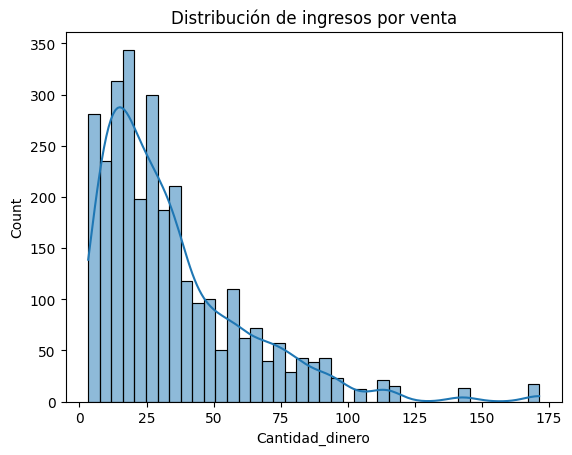

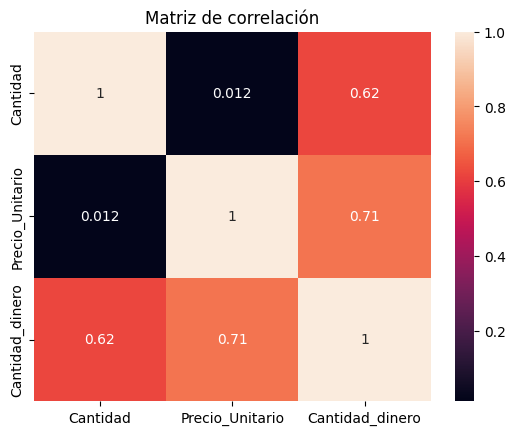

In [13]:
# Distribución de ingresos por venta
sns.histplot(df["Cantidad_dinero"], kde=True)
plt.title("Distribución de ingresos por venta")
plt.xlabel("Cantidad_dinero")
plt.show()

# Correlaciones entre variables numéricas
sns.heatmap(df[["Cantidad", "Precio_Unitario", "Cantidad_dinero"]].corr(), annot=True)
plt.title("Matriz de correlación")
plt.show()

### Evolución de cantidad de productos vendidos por día
La gráfica de evolución de cantidad de productos vendidos por día se construye a partir de la columna Fecha del DataFrame ventas, la cual se convierte a tipo datetime para facilitar el agrupamiento temporal. Luego, se agrupan todas las ventas por fecha y se suma la columna Cantidad, obteniendo así el número total de unidades vendidas cada día. En el gráfico resultante, el eje X representa el calendario (con fechas distribuidas cada 15 días), y el eje Y muestra la cantidad de productos vendidos. Esta gráfica permite observar el comportamiento de las ventas a lo largo del tiempo, identificar patrones de estacionalidad, tendencias, picos de demanda y posibles caídas.

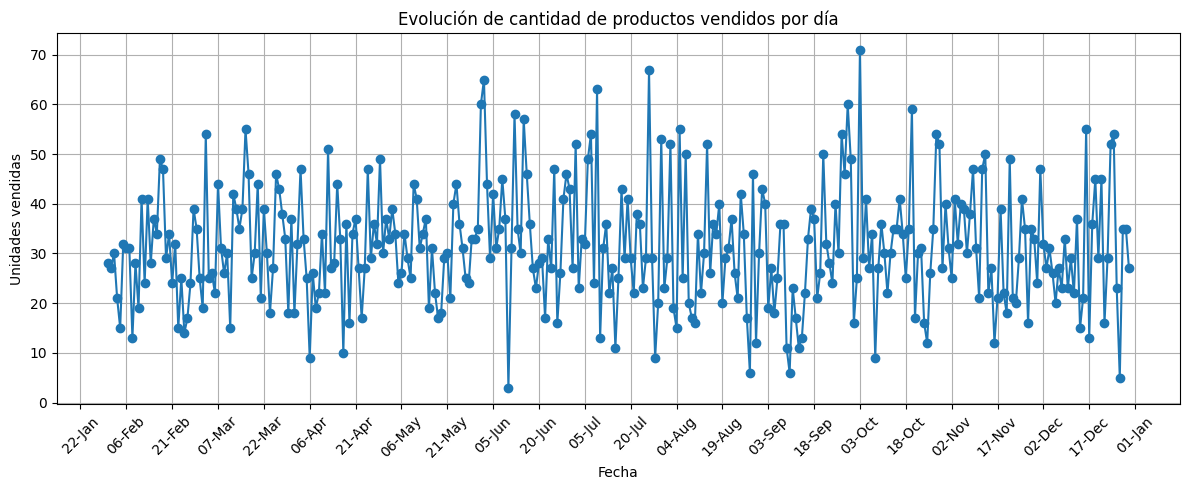

In [14]:

ventas["Fecha"] = pd.to_datetime(ventas["Fecha"], format="%d/%m/%Y")
ventas_diarias = ventas.groupby("Fecha")[["Cantidad"]].sum().reset_index()


plt.figure(figsize=(12, 5))
plt.plot(ventas_diarias["Fecha"], ventas_diarias["Cantidad"], marker='o')
plt.title("Evolución de cantidad de productos vendidos por día")
plt.xlabel("Fecha")
plt.ylabel("Unidades vendidas")
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

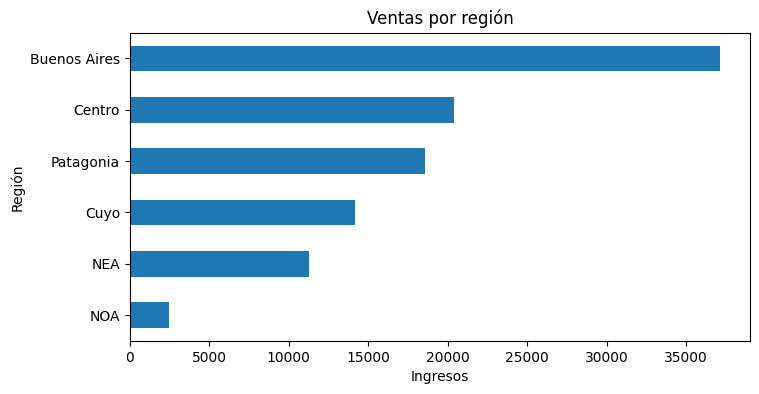

In [15]:
# Ventas por región 
df.groupby("Región")["Cantidad_dinero"].sum().sort_values().plot(kind="barh", title="Ventas por región", figsize=(8,4))
plt.xlabel("Ingresos")
plt.show()

In [16]:
print(productos.columns)


Index(['ID_Producto', 'Nombre_producto', 'Categoría', 'Precio_Unitario',
       'Stock'],
      dtype='object')


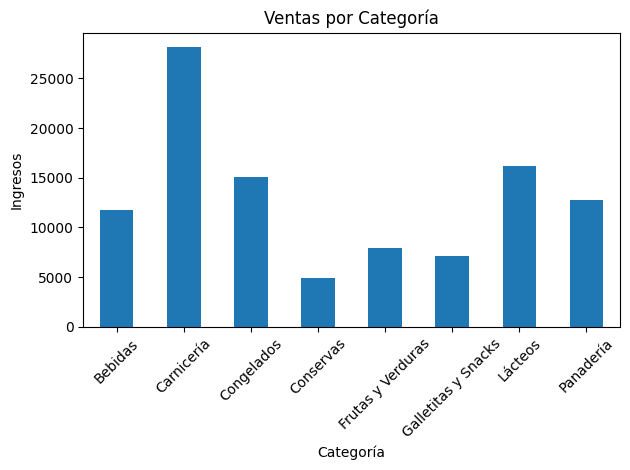

In [17]:
# --- Ventas por categoría ---
ventas_categoria.plot(kind="bar", title="Ventas por Categoría")
plt.ylabel("Ingresos")
plt.xlabel("Categoría")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


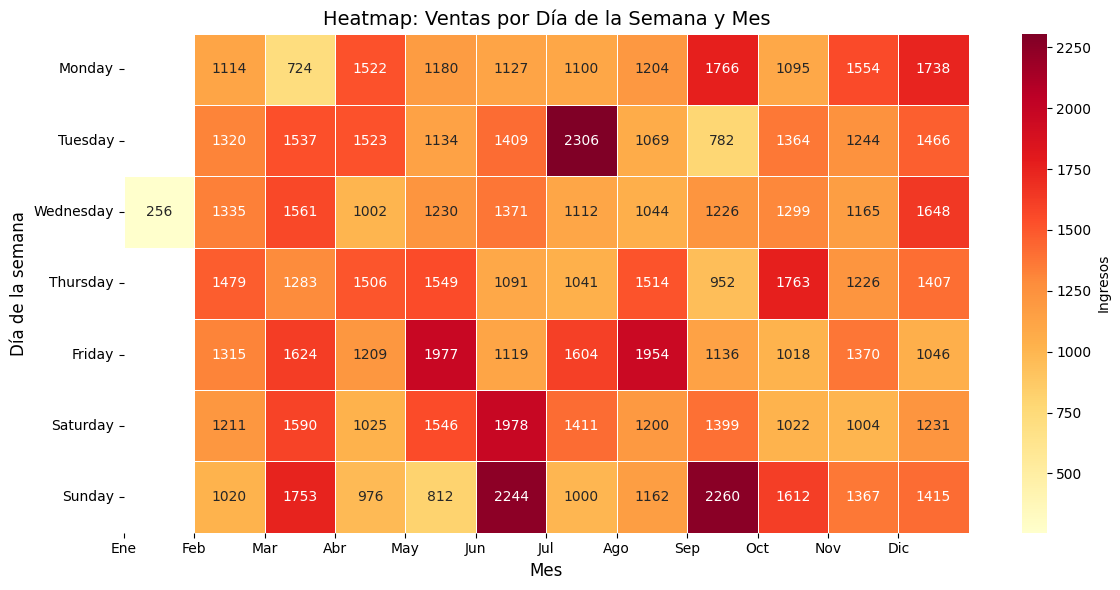

In [18]:

df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d/%m/%Y")
df["Día_semana"] = df["Fecha"].dt.day_name()
df["Mes"] = df["Fecha"].dt.month


heatmap_data = df.groupby(["Día_semana", "Mes"])["Cantidad_dinero"].sum().unstack()


dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(dias_orden)


plt.figure(figsize=(12, 6))  

sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"label": "Ingresos"}
)

plt.title("Heatmap: Ventas por Día de la Semana y Mes", fontsize=14)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Día de la semana", fontsize=12)

plt.xticks(ticks=range(12), labels=[
    'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
], rotation=0)

plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [19]:
productos_vendidos_sorted = productos_vendidos.sort_values("Cantidad_vendida", ascending=False)
fig = go.Figure()

fig.add_trace(go.Bar(
    x=productos_vendidos_sorted["ID_Producto"].astype(str),
    y=productos_vendidos_sorted["Stock"],
    name="Stock Total",
    opacity=1
))


fig.add_trace(go.Bar(
    x=productos_vendidos_sorted["ID_Producto"].astype(str),
    y=productos_vendidos_sorted["Producto_actual_stock"],
    name="Stock Restante",
    opacity=1
))

fig.update_layout(
    title="Stock Total vs Stock Restante por Producto",
    xaxis_title="ID Producto",
    yaxis_title="Cantidad",
    barmode='overlay',
    width=1000,
    height=600

)

fig.show()

In [20]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=productos_vendidos_sorted["ID_Producto"].astype(str),
    y=productos_vendidos_sorted["Cantidad_vendida"],
    name="Cantidad Vendida",
    marker=dict(
        color=productos_vendidos_sorted["Cantidad_vendida"],
        colorscale='Inferno',
        showscale=True,
        colorbar=dict(title="Cantidad")
    ),
    opacity=1
))

fig.update_layout(
    title="Cantidad Vendida por Producto",
    xaxis_title="ID Producto",
    yaxis_title="Cantidad Vendida",
    width=1000,
    height=600
)

fig.show()

## 4.4 Segmentación y Clustering (peso alto)

In [21]:
# Preparar datos para clustering
cluster_data = productos_vendidos[['Cantidad_vendida', 'Stock', 'Producto_actual_stock']].copy()
cluster_data["Porcentaje_venta"] = (cluster_data["Cantidad_vendida"] / cluster_data["Stock"]) * 100


In [22]:
#  Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_data)

In [23]:
# Evaluar número óptimo de clusters
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

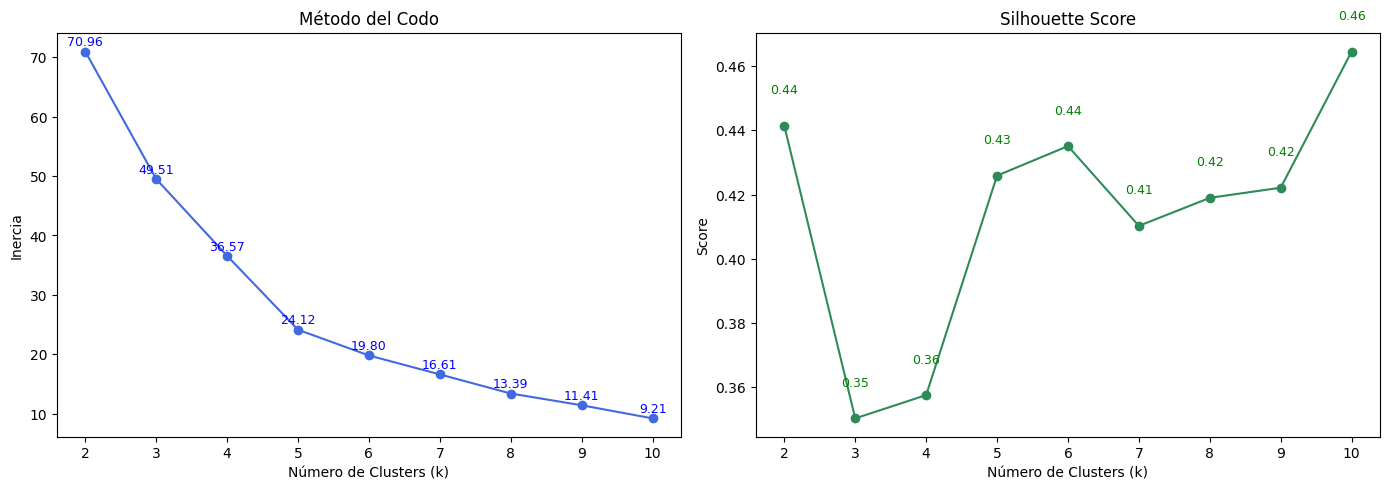

In [24]:
plt.figure(figsize=(14, 5))

# Gráfico del Método del Codo
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o', linestyle='-', color='royalblue')
plt.title("Método del Codo")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia")


for i, (k, inertia) in enumerate(zip(K_range, inertias)):
    plt.text(k, inertia + 1, f"{inertia:.2f}", ha='center', fontsize=9, color='blue')

# Gráfico del Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, marker='o', linestyle='-', color='seagreen')
plt.title("Silhouette Score")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Score")


for i, (k, score) in enumerate(zip(K_range, silhouettes)):
    plt.text(k, score + 0.01, f"{score:.2f}", ha='center', fontsize=9, color='green')

plt.tight_layout()
plt.show()





Para seleccionar el número óptimo de clústeres ($k$), hemos evaluado dos métricas clave: el **Método del Codo (Inercia)** y el **Coeficiente de Silhouette**.

* El gráfico de **Inercia** muestra una fuerte caída en la varianza dentro de los grupos hasta llegar a **$k=4$**, indicando que la mayor parte de la información se agrupa eficientemente en este punto .
* Aunque el **Coeficiente de Silhouette** alcanza su máximo en $k=10$, un $k$ tan alto resulta poco práctico para el análisis de negocio y la interpretación de los patrones de demanda. Por lo tanto, seleccionamos **$k=4$**  que tiene el segundo valor más alto.

 Este valor representa el mejor  equilibrio entre los dos métodos .

In [25]:


# Aplicar KMeans con k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Añadir ID_Producto para referencia
cluster_data['ID_Producto'] = productos_vendidos['ID_Producto'].values

# Resumen de clusters
print("Resumen de Clusters:")
print(cluster_data.groupby('Cluster').agg({
    'Cantidad_vendida': ['mean', 'sum', 'count'],
    'Stock': 'mean',
    'Porcentaje_venta': 'mean'
}).round(2))

Resumen de Clusters:
        Cantidad_vendida                Stock Porcentaje_venta
                    mean   sum count     mean             mean
Cluster                                                       
0                 278.00  3058    11  4579.18             6.08
1                 249.83  1499     6  1743.83            14.72
2                 265.07  3976    15  3156.47             8.50
3                 332.33  1994     6  1836.83            18.63


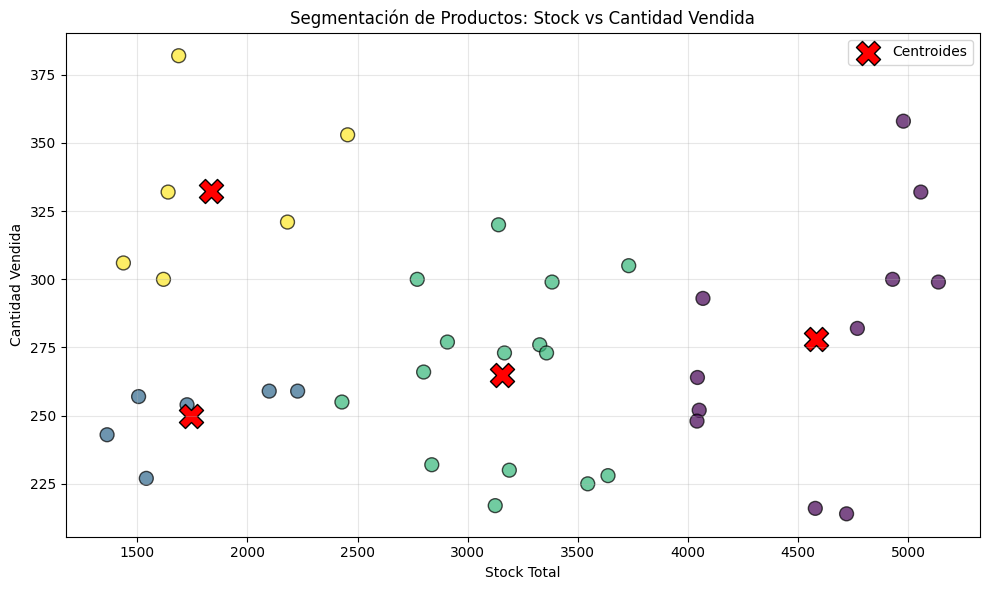

In [58]:
# Visualización 1: Scatter Plot 2D - Cantidad Vendida vs Stock
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    cluster_data['Stock'], 
    cluster_data['Cantidad_vendida'], 
    c=cluster_data['Cluster'], 
    #cmap='viridis', 
    s=100, 
    alpha=0.7,
    edgecolors='black'
)
#plt.colorbar(scatter, label='Cluster')
plt.xlabel('Stock Total')
plt.ylabel('Cantidad Vendida')
plt.title('Segmentación de Productos: Stock vs Cantidad Vendida')

# Añadir centroides
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', marker='X', s=300, edgecolors='black', label='Centroides')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
# Visualización 2: Scatter Plot interactivo con Plotly
fig = px.scatter(
    cluster_data,
    x='Stock',
    y='Cantidad_vendida',
    color='Cluster',
    size='Porcentaje_venta',
    hover_data=['ID_Producto', 'Porcentaje_venta', 'Producto_actual_stock'],
    title='Segmentación de Productos por Cluster (Interactivo)',
    labels={
        'Stock': 'Stock Total',
        'Cantidad_vendida': 'Cantidad Vendida',
        'Cluster': 'Cluster'
    },
    color_continuous_scale='viridis'
)
fig.update_layout(width=900, height=600)
fig.show()

/tmp/ipykernel_16994/754896664.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_16994/754896664.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_16994/754896664.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_16994/754896664.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




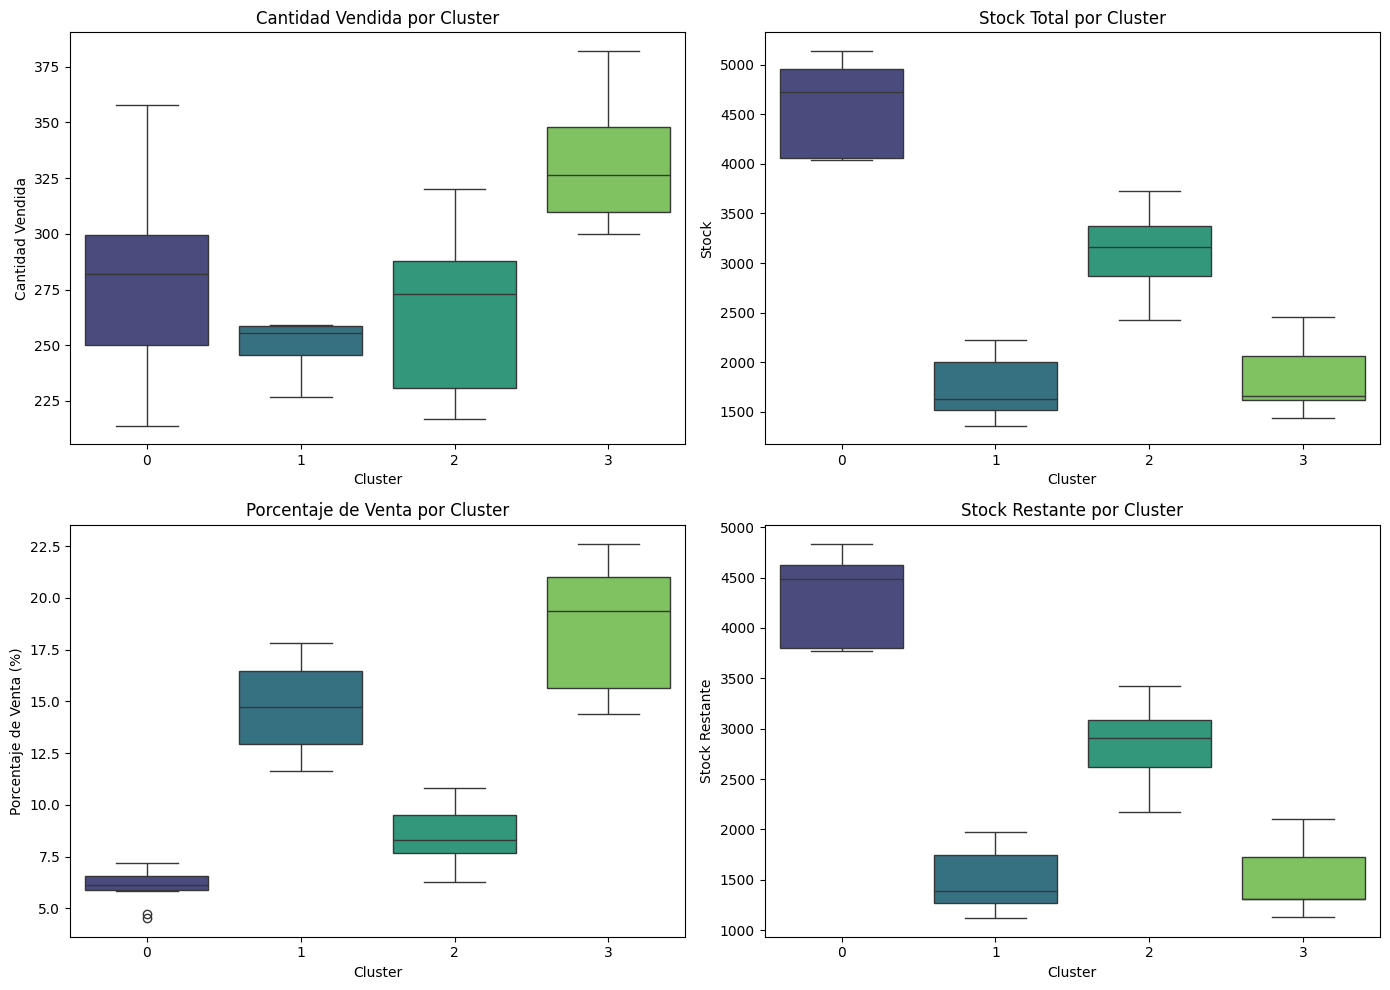

In [28]:
# Visualización 3: Boxplot de características por cluster
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cantidad Vendida por Cluster
sns.boxplot(data=cluster_data, x='Cluster', y='Cantidad_vendida', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Cantidad Vendida por Cluster')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Cantidad Vendida')

# Stock por Cluster
sns.boxplot(data=cluster_data, x='Cluster', y='Stock', ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Stock Total por Cluster')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Stock')

# Porcentaje de Venta por Cluster
sns.boxplot(data=cluster_data, x='Cluster', y='Porcentaje_venta', ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Porcentaje de Venta por Cluster')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Porcentaje de Venta (%)')

# Stock Restante por Cluster
sns.boxplot(data=cluster_data, x='Cluster', y='Producto_actual_stock', ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('Stock Restante por Cluster')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Stock Restante')

plt.tight_layout()
plt.show()

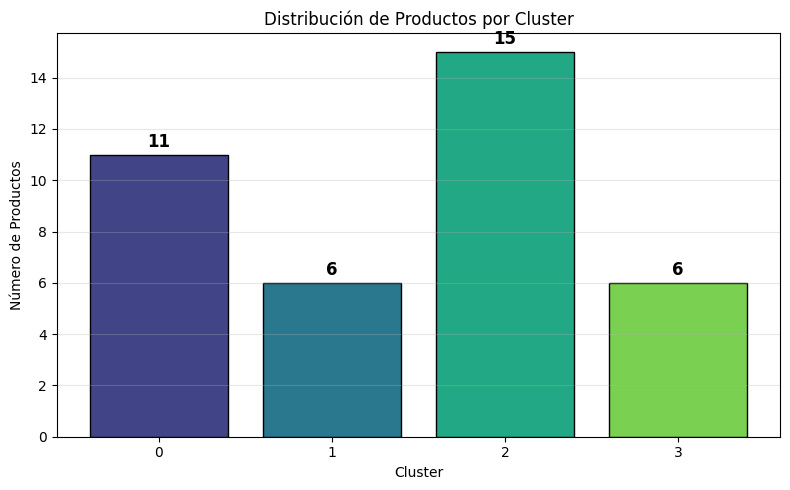

In [29]:
# Visualización 4: Gráfico de barras - Distribución de productos por cluster
plt.figure(figsize=(8, 5))
cluster_counts = cluster_data['Cluster'].value_counts().sort_index()
bars = plt.bar(cluster_counts.index, cluster_counts.values, color=plt.cm.viridis([0.2, 0.4, 0.6, 0.8]), edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Número de Productos')
plt.title('Distribución de Productos por Cluster')

# Añadir etiquetas en las barras
for bar, count in zip(bars, cluster_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, str(count), ha='center', fontsize=12, fontweight='bold')

plt.xticks([0, 1, 2, 3])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

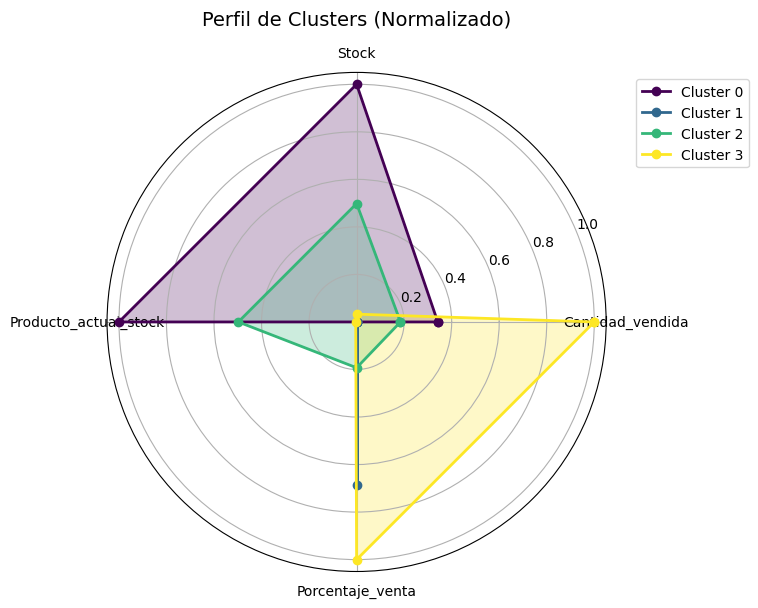

In [30]:
# Visualización 5: Radar Chart / Gráfico de araña para perfiles de clusters
from math import pi

# Calcular medias por cluster
cluster_means = cluster_data.groupby('Cluster')[['Cantidad_vendida', 'Stock', 'Producto_actual_stock', 'Porcentaje_venta']].mean()

# Normalizar para el radar chart
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# Configurar radar chart
categories = list(cluster_means_norm.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors = ['#440154', '#31688e', '#35b779', '#fde725']
for idx, (cluster, row) in enumerate(cluster_means_norm.iterrows()):
    values = row.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster}', color=colors[idx])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_title('Perfil de Clusters (Normalizado)', size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

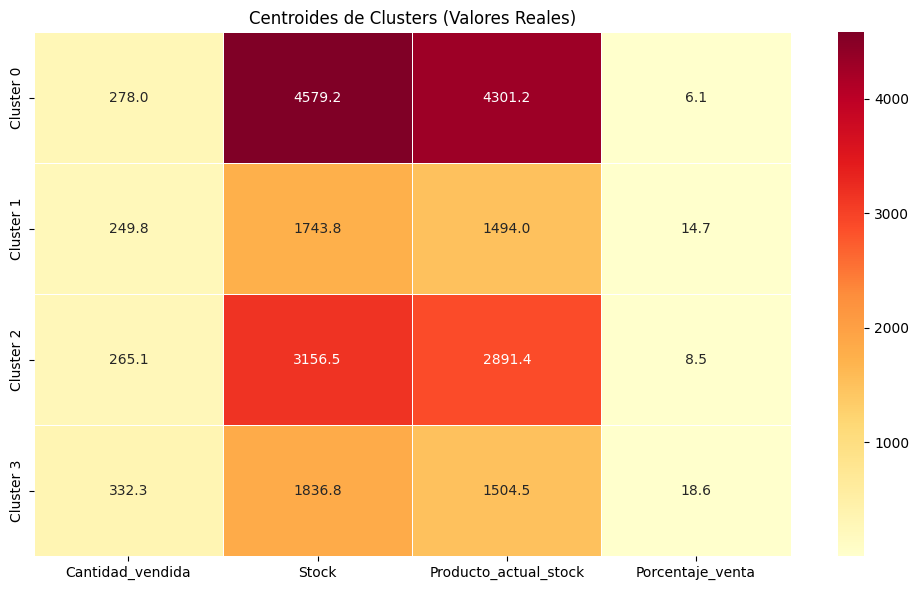


INTERPRETACIÓN DE CLUSTERS

Cluster 0:
  - Productos: 11
  - Cantidad vendida promedio: 278.0
  - Stock promedio: 4579.2
  - Porcentaje de venta promedio: 6.1%

Cluster 1:
  - Productos: 6
  - Cantidad vendida promedio: 249.8
  - Stock promedio: 1743.8
  - Porcentaje de venta promedio: 14.7%

Cluster 2:
  - Productos: 15
  - Cantidad vendida promedio: 265.1
  - Stock promedio: 3156.5
  - Porcentaje de venta promedio: 8.5%

Cluster 3:
  - Productos: 6
  - Cantidad vendida promedio: 332.3
  - Stock promedio: 1836.8
  - Porcentaje de venta promedio: 18.6%


In [31]:
# Visualización 6: Heatmap de centroides
plt.figure(figsize=(10, 6))
centroid_df = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=['Cantidad_vendida', 'Stock', 'Producto_actual_stock', 'Porcentaje_venta'],
    index=[f'Cluster {i}' for i in range(4)]
)

sns.heatmap(centroid_df, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5)
plt.title('Centroides de Clusters (Valores Reales)')
plt.tight_layout()
plt.show()

# Interpretación de clusters
print("\n" + "="*60)
print("INTERPRETACIÓN DE CLUSTERS")
print("="*60)
for cluster in range(4):
    print(f"\nCluster {cluster}:")
    cluster_info = cluster_data[cluster_data['Cluster'] == cluster]
    print(f"  - Productos: {len(cluster_info)}")
    print(f"  - Cantidad vendida promedio: {cluster_info['Cantidad_vendida'].mean():.1f}")
    print(f"  - Stock promedio: {cluster_info['Stock'].mean():.1f}")
    print(f"  - Porcentaje de venta promedio: {cluster_info['Porcentaje_venta'].mean():.1f}%")

In [32]:
# Importaciones adicionales para regresión y boosting
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [35]:
# Preparar datos completos para regresión (unir con más features)
df_regression = df.groupby('ID_Producto').agg({
    'Cantidad': 'sum',
    'Cantidad_dinero': 'sum',
    'Precio_Unitario': 'first',
    'Región': lambda x: x.value_counts().index[0],  # Región más frecuente
    'Categoría': 'first'
}).reset_index()

df_regression = df_regression.merge(
    cluster_data[['ID_Producto', 'Cluster', 'Stock', 'Cantidad_vendida', 'Porcentaje_venta', 'Producto_actual_stock']], 
    on='ID_Producto'
)

# Crear variables dummy para categorías
df_regression = pd.get_dummies(df_regression, columns=['Región', 'Categoría'], drop_first=True)

print("Dataset para regresión:")
print(df_regression.head())
print(f"\nForma del dataset: {df_regression.shape}")

Dataset para regresión:
   ID_Producto  Cantidad  Cantidad_dinero  Precio_Unitario  Cluster  Stock  \
0            1       276          3378.24            12.24        2   3327   
1            2       273          1422.33             5.21        2   3358   
2            3       273          4703.79            17.23        2   3167   
3            4       259          4980.57            19.23        1   2099   
4            5       300          1695.00             5.65        0   4929   

   Cantidad_vendida  Porcentaje_venta  Producto_actual_stock  Región_Centro  \
0               276          8.295762                   3051          False   
1               273          8.129839                   3085          False   
2               273          8.620145                   2894          False   
3               259         12.339209                   1840          False   
4               300          6.086427                   4629          False   

   Región_Patagonia  Categoría_C

In [38]:
# =============================================================================
# REGRESIÓN MÚLTIPLE POR CADA CLUSTER
# =============================================================================

print("="*70)
print("REGRESIÓN MÚLTIPLE POR CLUSTER")
print("="*70)

# Variable objetivo: Cantidad_dinero (ingresos totales)
# Variables predictoras: Stock, Precio_Unitario, y dummies

resultados_regresion = {}

for cluster_id in sorted(df_regression['Cluster'].unique()):
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}")
    print("="*70)
    
    # Filtrar datos del cluster
    df_cluster = df_regression[df_regression['Cluster'] == cluster_id].copy()
    
    if len(df_cluster) < 5:
        print(f"  ⚠️ Cluster {cluster_id} tiene muy pocos datos ({len(df_cluster)}). Saltando...")
        continue
    
    # Definir variables - excluir columnas no numéricas también
    feature_cols = [col for col in df_cluster.columns if col not in 
                   ['ID_Producto', 'Cluster', 'Cantidad_dinero', 'Cantidad_vendida', 'Cantidad']]
    
    X = df_cluster[feature_cols].copy()
    y = df_cluster['Cantidad_dinero'].copy()
    
    # Asegurar que X solo tenga columnas numéricas
    X = X.select_dtypes(include=['number'])
    
    # Eliminar columnas con varianza cero o NaN
    X = X.dropna(axis=1, how='any')
    X = X.loc[:, X.std() > 0]
    
    # Verificar que hay suficientes features
    if X.shape[1] < 1:
        print(f"  ⚠️ No hay suficientes variables predictoras. Saltando...")
        continue
    
    # Verificar que hay suficientes observaciones vs features
    if len(X) <= X.shape[1] + 1:
        print(f"  ⚠️ Más variables ({X.shape[1]}) que observaciones ({len(X)}). Saltando regresión OLS...")
        continue
    
    try:
        # Regresión con statsmodels (para obtener estadísticas detalladas)
        X_const = sm.add_constant(X, has_constant='add')
        model_sm = sm.OLS(y, X_const).fit()
        
        print(f"\n📊 Resumen del Modelo - Cluster {cluster_id}")
        print(f"   Observaciones: {len(df_cluster)}")
        print(f"   Variables: {X.shape[1]}")
        print(f"   R² ajustado: {model_sm.rsquared_adj:.4f}")
        
        # Manejar caso donde f_pvalue puede ser nan
        if not pd.isna(model_sm.fvalue):
            print(f"   F-statistic: {model_sm.fvalue:.4f}")
            print(f"   Prob(F-statistic): {model_sm.f_pvalue:.4e}")
        
        print(f"\n📈 Coeficientes significativos (p < 0.05):")
        significant = model_sm.pvalues[model_sm.pvalues < 0.05]
        if len(significant) > 0:
            for var in significant.index:
                coef = model_sm.params[var]
                pval = model_sm.pvalues[var]
                print(f"   {var}: β = {coef:.4f}, p-value = {pval:.4e}")
        else:
            print("   Ningún coeficiente significativo encontrado")
        
        # Regresión con sklearn para predicciones
        if len(df_cluster) >= 10:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        else:
            X_train, X_test, y_train, y_test = X, X, y, y
        
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        y_pred = lr_model.predict(X_test)
        
        # Métricas
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"\n📉 Métricas de Predicción:")
        print(f"   RMSE: {rmse:.2f}")
        print(f"   MAE: {mae:.2f}")
        print(f"   R²: {r2:.4f}")
        
        resultados_regresion[cluster_id] = {
            'modelo': model_sm,
            'r2_adj': model_sm.rsquared_adj,
            'rmse': rmse,
            'n_obs': len(df_cluster),
            'coeficientes': model_sm.params
        }
        
    except Exception as e:
        print(f"  ❌ Error en cluster {cluster_id}: {str(e)}")
        continue

print(f"\n\n✅ Regresiones completadas para {len(resultados_regresion)} clusters")

REGRESIÓN MÚLTIPLE POR CLUSTER

CLUSTER 0

📊 Resumen del Modelo - Cluster 0
   Observaciones: 11
   Variables: 4
   R² ajustado: 0.9930
   F-statistic: 354.6906
   Prob(F-statistic): 2.9779e-07

📈 Coeficientes significativos (p < 0.05):
   Precio_Unitario: β = 281.7827, p-value = 5.2961e-08

📉 Métricas de Predicción:
   RMSE: 422.50
   MAE: 385.12
   R²: -0.1655

CLUSTER 1

📊 Resumen del Modelo - Cluster 1
   Observaciones: 6
   Variables: 4
   R² ajustado: 0.9991
   F-statistic: 1423.4274
   Prob(F-statistic): 1.9876e-02

📈 Coeficientes significativos (p < 0.05):
   Precio_Unitario: β = 252.1808, p-value = 1.1430e-02

📉 Métricas de Predicción:
   RMSE: 18.73
   MAE: 16.86
   R²: 0.9998

CLUSTER 2

📊 Resumen del Modelo - Cluster 2
   Observaciones: 15
   Variables: 4
   R² ajustado: 0.9852
   F-statistic: 234.0094
   Prob(F-statistic): 7.8481e-10

📈 Coeficientes significativos (p < 0.05):
   Precio_Unitario: β = 271.4346, p-value = 6.9793e-11

📉 Métricas de Predicción:
   RMSE: 199.05


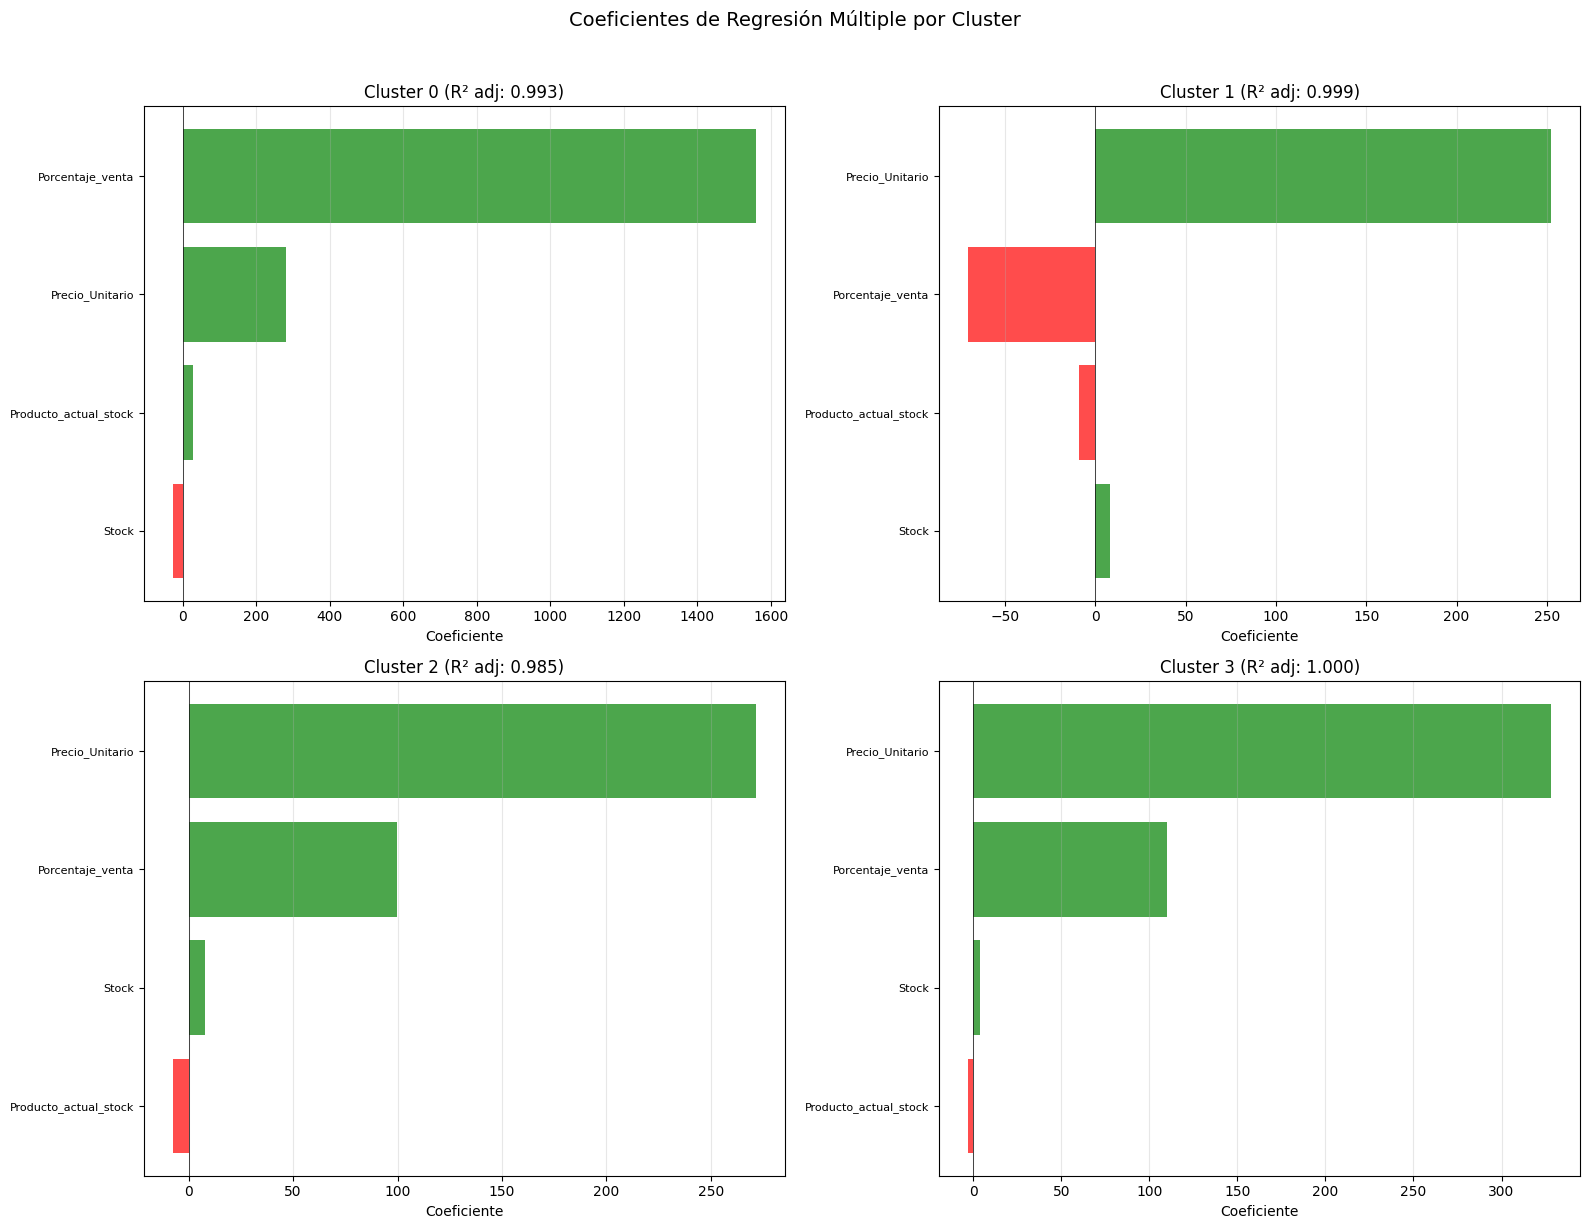

In [39]:
# Visualización de coeficientes por cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, cluster_id in enumerate(sorted(resultados_regresion.keys())):
    if idx >= 4:
        break
    
    coefs = resultados_regresion[cluster_id]['coeficientes']
    coefs = coefs.drop('const', errors='ignore')
    
    # Ordenar por valor absoluto
    coefs_sorted = coefs.reindex(coefs.abs().sort_values(ascending=True).index)
    
    colors = ['green' if x > 0 else 'red' for x in coefs_sorted.values]
    
    axes[idx].barh(range(len(coefs_sorted)), coefs_sorted.values, color=colors, alpha=0.7)
    axes[idx].set_yticks(range(len(coefs_sorted)))
    axes[idx].set_yticklabels(coefs_sorted.index, fontsize=8)
    axes[idx].set_xlabel('Coeficiente')
    axes[idx].set_title(f'Cluster {cluster_id} (R² adj: {resultados_regresion[cluster_id]["r2_adj"]:.3f})')
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Coeficientes de Regresión Múltiple por Cluster', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [40]:
# =============================================================================
# ÁRBOLES BOOSTING - GRADIENT BOOSTING, ADABOOST Y XGBOOST
# =============================================================================

print("\n" + "="*70)
print("MODELOS DE BOOSTING")
print("="*70)

# Preparar datos globales
feature_cols_global = [col for col in df_regression.columns if col not in 
                      ['ID_Producto', 'Cluster', 'Cantidad_dinero', 'Cantidad_vendida', 'Cantidad']]

X_global = df_regression[feature_cols_global]
y_global = df_regression['Cantidad_dinero']

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_global, y_global, test_size=0.25, random_state=42)

# Diccionario para almacenar modelos y resultados
boosting_models = {}

# 1. GRADIENT BOOSTING
print("\n" + "-"*50)
print("1. GRADIENT BOOSTING REGRESSOR")
print("-"*50)

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
gb_model.fit(X_train_g, y_train_g)
y_pred_gb = gb_model.predict(X_test_g)

gb_metrics = {
    'RMSE': mean_squared_error(y_test_g, y_pred_gb) ** 0.5,
    'MAE': mean_absolute_error(y_test_g, y_pred_gb),
    'R2': r2_score(y_test_g, y_pred_gb)
}

print(f"   RMSE: {gb_metrics['RMSE']:.2f}")
print(f"   MAE: {gb_metrics['MAE']:.2f}")
print(f"   R²: {gb_metrics['R2']:.4f}")

boosting_models['Gradient Boosting'] = {'model': gb_model, 'metrics': gb_metrics, 'predictions': y_pred_gb}

# 2. ADABOOST
print("\n" + "-"*50)
print("2. ADABOOST REGRESSOR")
print("-"*50)

ada_model = AdaBoostRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
ada_model.fit(X_train_g, y_train_g)
y_pred_ada = ada_model.predict(X_test_g)

ada_metrics = {
    'RMSE': mean_squared_error(y_test_g, y_pred_ada) ** 0.5,
    'MAE': mean_absolute_error(y_test_g, y_pred_ada),
    'R2': r2_score(y_test_g, y_pred_ada)
}

print(f"   RMSE: {ada_metrics['RMSE']:.2f}")
print(f"   MAE: {ada_metrics['MAE']:.2f}")
print(f"   R²: {ada_metrics['R2']:.4f}")

boosting_models['AdaBoost'] = {'model': ada_model, 'metrics': ada_metrics, 'predictions': y_pred_ada}

# 3. XGBOOST
print("\n" + "-"*50)
print("3. XGBOOST REGRESSOR")
print("-"*50)

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train_g, y_train_g)
y_pred_xgb = xgb_model.predict(X_test_g)

xgb_metrics = {
    'RMSE': mean_squared_error(y_test_g, y_pred_xgb) ** 0.5,
    'MAE': mean_absolute_error(y_test_g, y_pred_xgb),
    'R2': r2_score(y_test_g, y_pred_xgb)
}

print(f"   RMSE: {xgb_metrics['RMSE']:.2f}")
print(f"   MAE: {xgb_metrics['MAE']:.2f}")
print(f"   R²: {xgb_metrics['R2']:.4f}")

boosting_models['XGBoost'] = {'model': xgb_model, 'metrics': xgb_metrics, 'predictions': y_pred_xgb}


MODELOS DE BOOSTING

--------------------------------------------------
1. GRADIENT BOOSTING REGRESSOR
--------------------------------------------------
   RMSE: 853.74
   MAE: 649.55
   R²: 0.4661

--------------------------------------------------
2. ADABOOST REGRESSOR
--------------------------------------------------
   RMSE: 554.09
   MAE: 369.41
   R²: 0.7751

--------------------------------------------------
3. XGBOOST REGRESSOR
--------------------------------------------------
   RMSE: 575.10
   MAE: 385.12
   R²: 0.7577



COMPARACIÓN DE MODELOS DE BOOSTING
           Modelo       RMSE        MAE       R²
Gradient Boosting 853.743687 649.554159 0.466096
         AdaBoost 554.090150 369.405153 0.775110
          XGBoost 575.100669 385.123952 0.757732


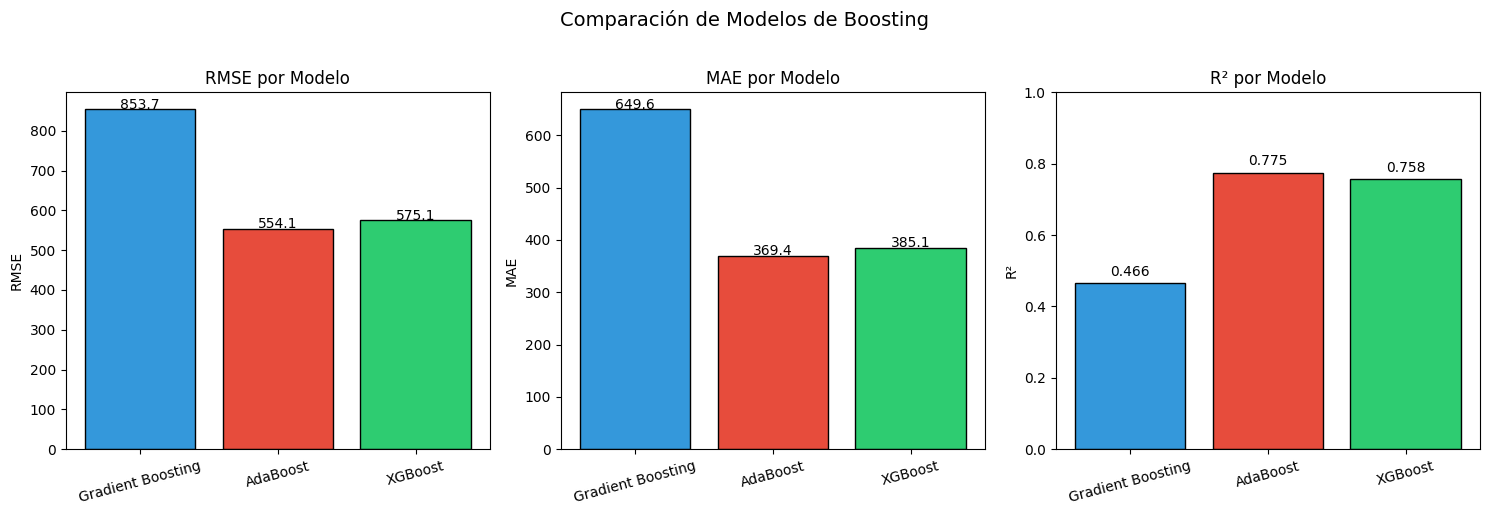

In [41]:
# Comparación de modelos de Boosting
print("\n" + "="*70)
print("COMPARACIÓN DE MODELOS DE BOOSTING")
print("="*70)

comparison_df = pd.DataFrame({
    'Modelo': list(boosting_models.keys()),
    'RMSE': [boosting_models[m]['metrics']['RMSE'] for m in boosting_models],
    'MAE': [boosting_models[m]['metrics']['MAE'] for m in boosting_models],
    'R²': [boosting_models[m]['metrics']['R2'] for m in boosting_models]
})

print(comparison_df.to_string(index=False))

# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE
bars1 = axes[0].bar(comparison_df['Modelo'], comparison_df['RMSE'], color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE por Modelo')
axes[0].tick_params(axis='x', rotation=15)
for bar, val in zip(bars1, comparison_df['RMSE']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}', ha='center', fontsize=10)

# MAE
bars2 = axes[1].bar(comparison_df['Modelo'], comparison_df['MAE'], color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE por Modelo')
axes[1].tick_params(axis='x', rotation=15)
for bar, val in zip(bars2, comparison_df['MAE']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}', ha='center', fontsize=10)

# R²
bars3 = axes[2].bar(comparison_df['Modelo'], comparison_df['R²'], color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
axes[2].set_ylabel('R²')
axes[2].set_title('R² por Modelo')
axes[2].tick_params(axis='x', rotation=15)
axes[2].set_ylim(0, 1)
for bar, val in zip(bars3, comparison_df['R²']):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', ha='center', fontsize=10)

plt.suptitle('Comparación de Modelos de Boosting', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

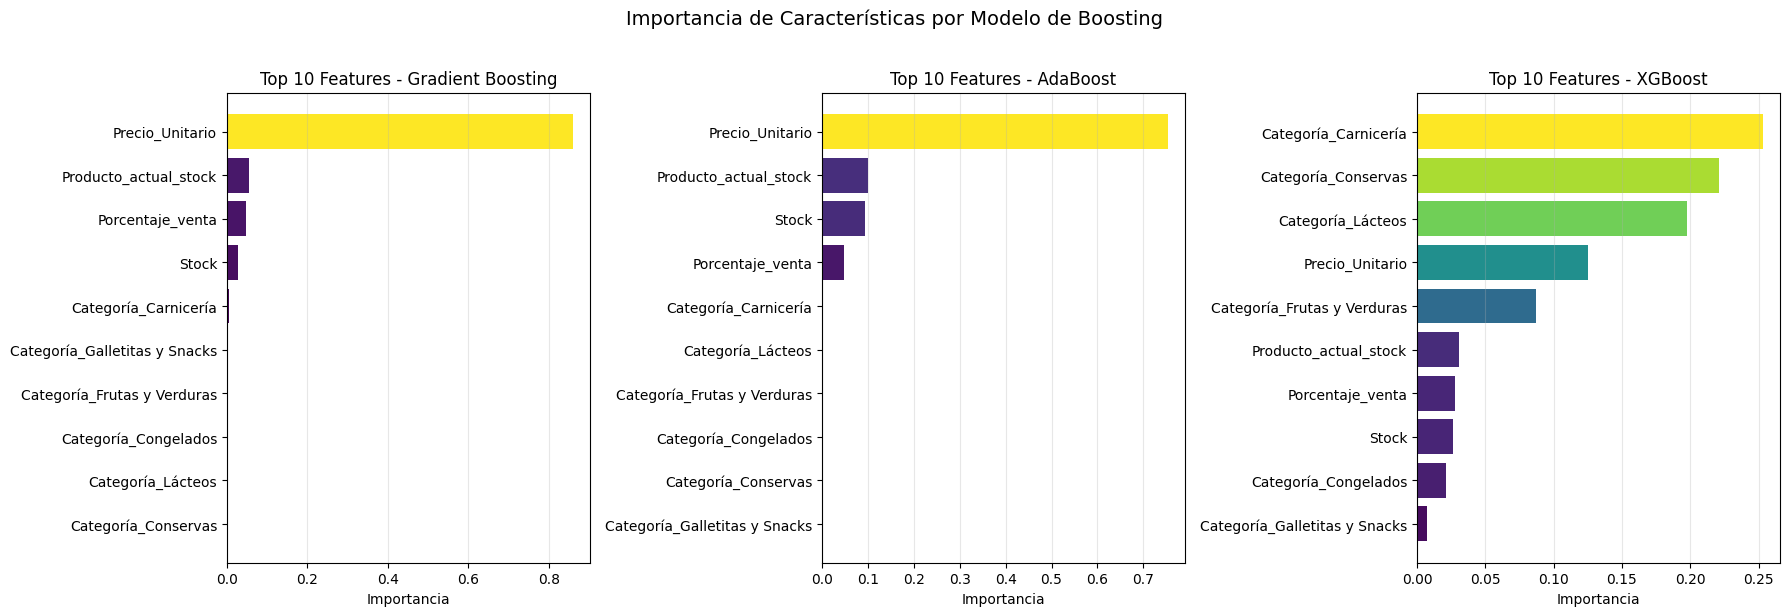

In [42]:
# Importancia de características para cada modelo de Boosting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (name, data) in enumerate(boosting_models.items()):
    model = data['model']
    
    # Obtener importancias
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols_global,
        'Importance': importances
    }).sort_values('Importance', ascending=True).tail(10)
    
    axes[idx].barh(feature_importance_df['Feature'], feature_importance_df['Importance'], 
                   color=plt.cm.viridis(feature_importance_df['Importance'] / feature_importance_df['Importance'].max()))
    axes[idx].set_xlabel('Importancia')
    axes[idx].set_title(f'Top 10 Features - {name}')
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Importancia de Características por Modelo de Boosting', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

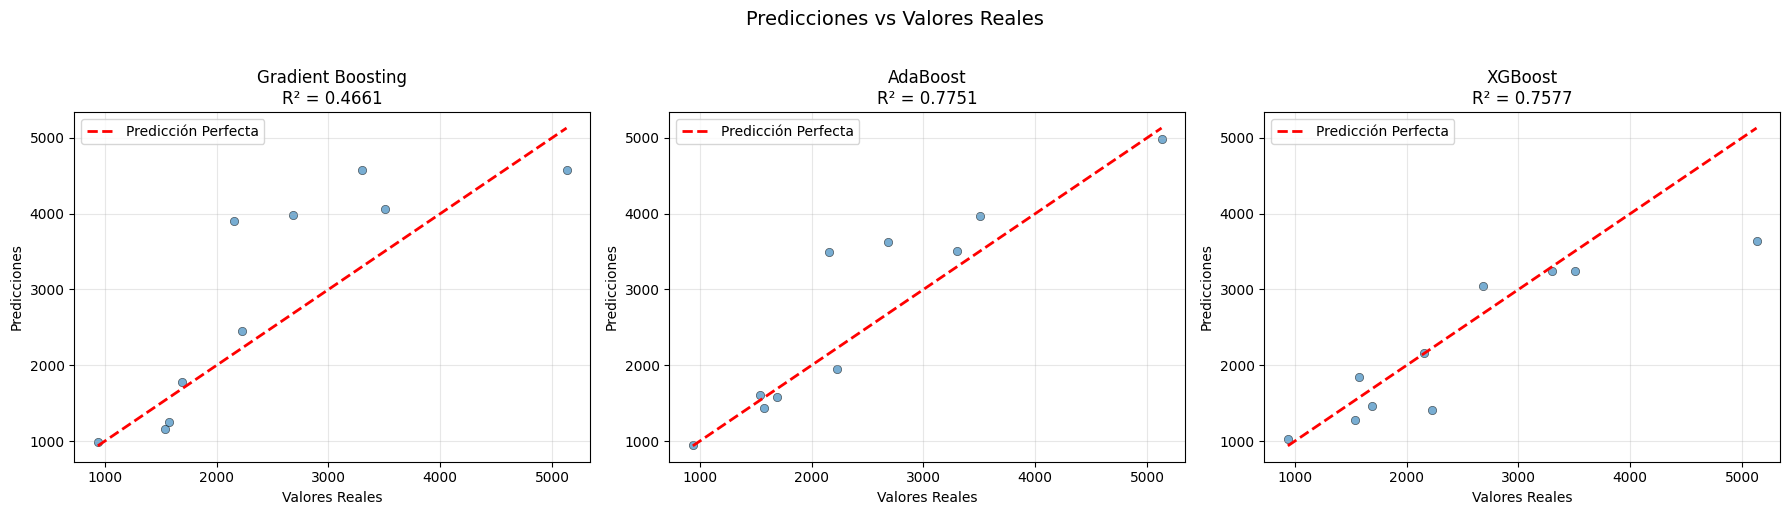

In [43]:
# Predicciones vs Valores Reales para cada modelo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, data) in enumerate(boosting_models.items()):
    y_pred = data['predictions']
    
    axes[idx].scatter(y_test_g, y_pred, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    # Línea de predicción perfecta
    min_val = min(y_test_g.min(), y_pred.min())
    max_val = max(y_test_g.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción Perfecta')
    
    axes[idx].set_xlabel('Valores Reales')
    axes[idx].set_ylabel('Predicciones')
    axes[idx].set_title(f'{name}\nR² = {data["metrics"]["R2"]:.4f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Predicciones vs Valores Reales', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

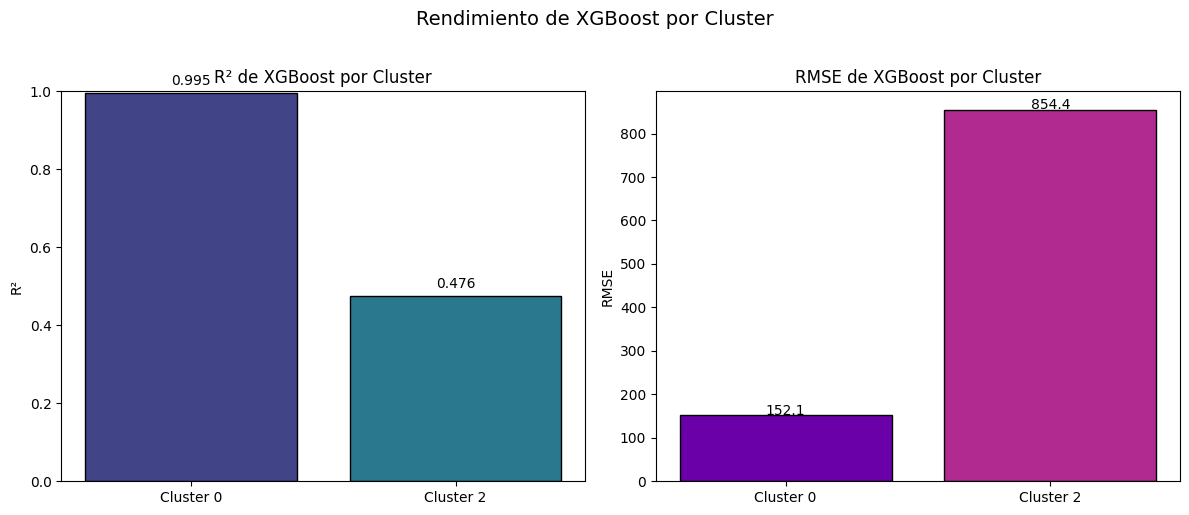

In [45]:
# Visualización de rendimiento de XGBoost por cluster
if resultados_xgb_cluster:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    clusters = list(resultados_xgb_cluster.keys())
    r2_scores = [resultados_xgb_cluster[c]['r2'] for c in clusters]
    rmse_scores = [resultados_xgb_cluster[c]['rmse'] for c in clusters]
    
    # R² por cluster
    bars1 = axes[0].bar([f'Cluster {c}' for c in clusters], r2_scores, 
                        color=plt.cm.viridis([0.2, 0.4, 0.6, 0.8][:len(clusters)]), edgecolor='black')
    axes[0].set_ylabel('R²')
    axes[0].set_title('R² de XGBoost por Cluster')
    axes[0].set_ylim(0, 1)
    for bar, val in zip(bars1, r2_scores):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', ha='center', fontsize=10)
    
    # RMSE por cluster
    bars2 = axes[1].bar([f'Cluster {c}' for c in clusters], rmse_scores,
                        color=plt.cm.plasma([0.2, 0.4, 0.6, 0.8][:len(clusters)]), edgecolor='black')
    axes[1].set_ylabel('RMSE')
    axes[1].set_title('RMSE de XGBoost por Cluster')
    for bar, val in zip(bars2, rmse_scores):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}', ha='center', fontsize=10)
    
    plt.suptitle('Rendimiento de XGBoost por Cluster', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

In [46]:
# Resumen final
print("\n" + "="*70)
print("RESUMEN FINAL DE MODELOS")
print("="*70)

print("\n📊 REGRESIÓN MÚLTIPLE POR CLUSTER:")
for cluster_id, data in resultados_regresion.items():
    print(f"   Cluster {cluster_id}: R² adj = {data['r2_adj']:.4f}, RMSE = {data['rmse']:.2f}, n = {data['n_obs']}")

print("\n🚀 MODELOS DE BOOSTING (Global):")
best_model = max(boosting_models.keys(), key=lambda x: boosting_models[x]['metrics']['R2'])
for name, data in boosting_models.items():
    indicator = "⭐" if name == best_model else "  "
    print(f" {indicator} {name}: R² = {data['metrics']['R2']:.4f}, RMSE = {data['metrics']['RMSE']:.2f}")

print(f"\n✅ Mejor modelo de Boosting: {best_model}")


RESUMEN FINAL DE MODELOS

📊 REGRESIÓN MÚLTIPLE POR CLUSTER:
   Cluster 0: R² adj = 0.9930, RMSE = 422.50, n = 11
   Cluster 1: R² adj = 0.9991, RMSE = 18.73, n = 6
   Cluster 2: R² adj = 0.9852, RMSE = 199.05, n = 15
   Cluster 3: R² adj = 1.0000, RMSE = 3.94, n = 6

🚀 MODELOS DE BOOSTING (Global):
    Gradient Boosting: R² = 0.4661, RMSE = 853.74
 ⭐ AdaBoost: R² = 0.7751, RMSE = 554.09
    XGBoost: R² = 0.7577, RMSE = 575.10

✅ Mejor modelo de Boosting: AdaBoost


In [47]:
# =============================================================================
# DASHBOARD Y VISUALIZACIONES - STORYTELLING
# =============================================================================

# Importaciones adicionales para dashboard
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.subplots as sp
from plotly.subplots import make_subplots
import numpy as np

In [53]:
# =============================================================================
# 6. MAPA DE CLÚSTERES - VISUALIZACIÓN AVANZADA
# =============================================================================

print("\n" + "="*70)
print("🎯 MAPA DE CLÚSTERES")
print("="*70)

# Crear visualización 3D de clusters
fig_clusters_3d = go.Figure()

colors_cluster = ['#440154', '#31688e', '#35b779', '#fde725']

for cluster_id in sorted(cluster_data['Cluster'].unique()):
    cluster_subset = cluster_data[cluster_data['Cluster'] == cluster_id]
    
    fig_clusters_3d.add_trace(go.Scatter3d(
        x=cluster_subset['Stock'],
        y=cluster_subset['Cantidad_vendida'],
        z=cluster_subset['Porcentaje_venta'],
        mode='markers',
        name=f'Cluster {cluster_id}',
        marker=dict(
            size=8,
            color=colors_cluster[cluster_id],
            opacity=0.8,
            line=dict(width=1, color='white')
        ),
        text=[f'ID: {id}<br>Stock: {s}<br>Vendido: {v}<br>%Venta: {p:.1f}%' 
              for id, s, v, p in zip(cluster_subset['ID_Producto'], 
                                     cluster_subset['Stock'],
                                     cluster_subset['Cantidad_vendida'],
                                     cluster_subset['Porcentaje_venta'])],
        hoverinfo='text'
    ))

# Añadir centroides
centroids_inv = scaler.inverse_transform(kmeans.cluster_centers_)
fig_clusters_3d.add_trace(go.Scatter3d(
    x=centroids_inv[:, 1],  # Stock
    y=centroids_inv[:, 0],  # Cantidad_vendida
    z=centroids_inv[:, 3],  # Porcentaje_venta
    mode='markers',
    name='Centroides',
    marker=dict(
        size=15,
        color='red',
        symbol='diamond',
        line=dict(width=2, color='black')
    )
))

fig_clusters_3d.update_layout(
    title_text="🎯 Mapa 3D de Clústeres de Productos",
    scene=dict(
        xaxis_title='Stock Total',
        yaxis_title='Cantidad Vendida',
        zaxis_title='Porcentaje de Venta (%)'
    ),
    height=700,
    width=1000
)
fig_clusters_3d.show()


🎯 MAPA DE CLÚSTERES


In [56]:
# =============================================================================
# 9. DASHBOARD INTERACTIVO CONSOLIDADO
# =============================================================================

print("\n" + "="*70)
print("🖥️ DASHBOARD CONSOLIDADO FINAL")
print("="*70)

# Crear dashboard final con todos los elementos clave
fig_dashboard = make_subplots(
    rows=3, cols=3,
    subplot_titles=(
        'KPI: Ingresos Totales', 'Tendencia de Ventas', 'Top Regiones',
        'Distribución por Cluster', 'Estacionalidad Semanal', 'Categorías',
        'Importancia de Variables', 'Predicciones vs Real', 'Métricas de Modelo'
    ),
    specs=[
        [{"type": "indicator"}, {"type": "scatter"}, {"type": "bar"}],
        [{"type": "pie"}, {"type": "bar"}, {"type": "bar"}],
        [{"type": "bar"}, {"type": "scatter"}, {"type": "indicator"}]
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.08
)

# Row 1
# KPI Ingresos
fig_dashboard.add_trace(
    go.Indicator(mode="number", value=total_ventas, 
                 number={'prefix': "$", 'valueformat': ',.0f'}),
    row=1, col=1
)

# Tendencia
fig_dashboard.add_trace(
    go.Scatter(x=ventas_diarias.index, y=ventas_diarias['Cantidad_dinero'],
               mode='lines', line=dict(color='royalblue')),
    row=1, col=2
)

# Top Regiones
fig_dashboard.add_trace(
    go.Bar(x=ventas_region.head(5)['Región'], 
           y=ventas_region.head(5)['Ingresos'],
           marker_color='steelblue'),
    row=1, col=3
)

# Row 2
# Clusters Pie
cluster_dist = cluster_data['Cluster'].value_counts()
fig_dashboard.add_trace(
    go.Pie(labels=[f'Cluster {i}' for i in cluster_dist.index],
           values=cluster_dist.values, hole=0.4),
    row=2, col=1
)

# Estacionalidad
fig_dashboard.add_trace(
    go.Bar(x=dias_espanol, y=ventas_dia.values, marker_color='coral'),
    row=2, col=2
)

# Categorías
fig_dashboard.add_trace(
    go.Bar(x=ventas_categoria['Categoría'].astype(str).head(5),
           y=ventas_categoria['Ingresos'].head(5),
           marker_color='mediumseagreen'),
    row=2, col=3
)

# Row 3
# Importancia de variables (mejor modelo)
best_importance = pd.DataFrame({
    'Feature': feature_cols_global,
    'Importance': boosting_models[best_model]['model'].feature_importances_
}).nlargest(5, 'Importance')

fig_dashboard.add_trace(
    go.Bar(y=best_importance['Feature'], x=best_importance['Importance'],
           orientation='h', marker_color='purple'),
    row=3, col=1
)

# Predicciones vs Real
fig_dashboard.add_trace(
    go.Scatter(x=y_test_g, y=boosting_models[best_model]['predictions'],
               mode='markers', marker=dict(color='green', opacity=0.6)),
    row=3, col=2
)

# Métrica R²
fig_dashboard.add_trace(
    go.Indicator(
        mode="gauge+number",
        value=boosting_models[best_model]['metrics']['R2'],
        gauge={'axis': {'range': [0, 1]},
               'bar': {'color': "darkgreen"},
               'steps': [
                   {'range': [0, 0.5], 'color': "lightgray"},
                   {'range': [0.5, 0.75], 'color': "yellow"},
                   {'range': [0.75, 1], 'color': "lightgreen"}
               ]},
        title={'text': "R² Score"}
    ),
    row=3, col=3
)

fig_dashboard.update_layout(
    title_text="🖥️ DASHBOARD EJECUTIVO - ANÁLISIS MULTIVARIADO DE VENTAS",
    height=900,
    width=1400,
    showlegend=False
)
fig_dashboard.show()

print("\n✅ Dashboard generado exitosamente!")


🖥️ DASHBOARD CONSOLIDADO FINAL



✅ Dashboard generado exitosamente!
